In [0]:
from google.colab import files
import pickle

DATADIR = "/content/gdrive/My Drive/Machine Learning/tooploox"

from google.colab import drive
drive.mount('/content/gdrive')

def unpickle(file):
    with open(file, 'rb') as fo:
        obj = pickle.load(fo)
    return obj

def dopickle(obj, file):
  with open(file, 'wb') as target:
    pickle.dump(obj, target, protocol=pickle.HIGHEST_PROTOCOL)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
model = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


In [0]:
from tqdm import tqdm
x_train_vgg = []
x_test_vgg = []

for i in tqdm(range(len(x_train))):
  x = image.img_to_array(x_train[i])
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x_train_vgg.append(model.predict(x)[0][0][0])


100%|██████████| 50000/50000 [24:13<00:00, 34.93it/s]


In [0]:
from tqdm import tqdm
x_train_vgg = []
x_test_vgg = []

for i in tqdm(range(len(x_test))):
  x = image.img_to_array(x_test[i])
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x_test_vgg.append(model.predict(x)[0][0][0])


100%|██████████| 10000/10000 [06:14<00:00, 26.70it/s]


In [0]:
dopickle(x_train_vgg, DATADIR+"/x_train_vgg.pkl")

In [0]:
dopickle(x_test_vgg, DATADIR+"/x_test_vgg.pkl")

In [0]:
x_train_vgg2 = unpickle(DATADIR + "/x_train_vgg.pkl")
x_test_vgg2 = unpickle(DATADIR + "/x_test_vgg.pkl")
y_train = unpickle(DATADIR + "/y_train.pkl")
y_test = unpickle(DATADIR + "/y_test.pkl")
print(len(x_train_vgg2), x_train_vgg2[0].shape)
print(len(y_train), y_train)

In [0]:
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as knn
import numpy as np


def KNN(X, Y):
  skf = StratifiedKFold(n_splits=5)
  skf.get_n_splits(X, Y)

  clf = knn(n_neighbors=7, weights="distance", metric="euclidean")
  precisions = []
  for train, test in skf.split(X, Y):
    print(precisions)
    X_train = [X[i] for i in train]
    Y_train = [Y[i] for i in train]
    X_test = [X[i] for i in test]
    Y_test = [Y[i] for i in test]

    clf.fit(X_train, Y_train)
    preds = clf.predict(X_test)
    precisions.append(precision_score(Y_test, preds, average="macro"))

  return np.mean(precisions)

In [63]:
print(KNN(x_train_vgg2[:2000], y_train[:2000]))

[]
[0.47694702041620884]
[0.47694702041620884, 0.4450507574420949]
[0.47694702041620884, 0.4450507574420949, 0.47604260081679434]
[0.47694702041620884, 0.4450507574420949, 0.47604260081679434, 0.4987148008932116]
0.4773504358355402


In [0]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam

def create_model():
  anchor_input = Input(shape=(512,), name="anchor_input")
  positive_input = Input(shape=(512,), name="positive_input")
  negative_input = Input(shape=(512,), name="negative_input")
  
  model = Sequential()
  model.add(Dense(512, input_shape=(512,), activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='sigmoid'))
  
  encoded_anchor = model(anchor_input)
  encoded_positive = model(positive_input)
  encoded_negative = model(negative_input)
  
  merged_encodings = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name="merged_encodings")
  model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_encodings)
  return model, anchor_input, encoded_anchor

def triplet_loss(y_true, y_pred, alpha=0.4):
  total_length = y_pred.shape.as_list()[-1]
  anchor = y_pred[:,0:int(total_length*1/3)]
  positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
  negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]
  
  positive_distance = K.sum(K.square(anchor - positive), axis=1)
  negative_distance = K.sum(K.square(anchor - negative), axis=1)
  
  return K.maximum(positive_distance - negative_distance + alpha, 0.0)

In [44]:
adam_opt = Adam(lr=0.0001)
model, anchor_input, encoded_anchor = create_model()
model.compile(loss=triplet_loss, optimizer=adam_opt)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 512)          0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 512)          0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 512)          0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 128)          689536      anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

### Przygotowanie tripletów

In [0]:
def group_data(x, y):
  d = {}
  for i in range(10):
    d[i] = []
  for i in range(len(x)):
    clazz = y[i]
    d[clazz].append(x[i])
  return d

train = group_data(x_train_vgg2, y_train)
test = group_data(x_test_vgg2, y_test)

In [0]:
from scipy.spatial.distance import euclidean
from random import choice
from tqdm import tqdm

positives = []
anchors = []
negatives = []

d = train
for clazz in d:
  print(clazz, len(positives), len(anchors), len(negatives))
  for i in range(len(d[clazz])):
    positive = d[clazz][i]
    best = None
    diff = float('inf')
    for j in range(i//100, i//100 + 100):
      potential_anchor = d[clazz][j]
      dist = euclidean(positive, potential_anchor)
      if diff > dist and dist > 0.5:
        best = potential_anchor
        diff = dist
    anchors.append(best)
    tmp = list(range(10))
    tmp.remove(clazz)
    neg = choice(tmp)
    best = None
    diff = float('inf')
    for k in range(i//100, i//100 + 100):
      potential_negative = d[neg][k]
      dist = euclidean(potential_negative, positive)
      if diff > dist and dist > 0.5:
        best = potential_negative
        diff = dist
    positives.append(positive)
    negatives.append(best)

In [0]:
from scipy.spatial.distance import euclidean
from random import choice
from tqdm import tqdm


def triplets(dataset):

  positives = []
  anchors = []
  negatives = []

  d = dataset
  for clazz in d:
    print(clazz, len(positives), len(anchors), len(negatives))
    for i in range(len(d[clazz])):
      positive = d[clazz][i]
      best = None
      diff = float('inf')
      for j in range(i//100, i//100 + 100):
        potential_anchor = d[clazz][j]
        dist = euclidean(positive, potential_anchor)
        if diff > dist and dist > 0.5:
          best = potential_anchor
          diff = dist
      anchors.append(best)
      tmp = list(range(10))
      tmp.remove(clazz)
      neg = choice(tmp)
      best = None
      diff = float('inf')
      for k in range(i//100, i//100 + 100):
        potential_negative = d[neg][k]
        dist = euclidean(potential_negative, positive)
        if diff > dist and dist > 0.5:
          best = potential_negative
          diff = dist
      positives.append(positive)
      negatives.append(best)
  return (positives, anchors, negatives)

In [0]:
import numpy as np
tripples_train = unpickle(DATADIR + "/tripples_train.pkl")
tripples_test = unpickle(DATADIR + "/tripples_test.pkl")


Y_dummy = np.empty((len(tripples_train[1]),300))
Y_dummy2 = np.empty((len(tripples_test[1]),1))
model.fit([tripples_train[1], tripples_train[0], tripples_train[2]], y=Y_dummy,
         validation_data=([tripples_test[1], tripples_test[0], tripples_test[2]], Y_dummy2), batch_size=128, epochs=100)
model.save_weights(DATADIR+"/weights_100_128.hdf5")

In [0]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights(DATADIR+"/weights_100_128.hdf5")

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects



def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

# tsne = TSNE()
# train_tsne_embeds = tsne.fit_transform(np.asarray(x_train_vgg2[:1024]))
# scatter(train_tsne_embeds, np.asarray(y_train[:1024]), "Samples from initial encodings")

# eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
# scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

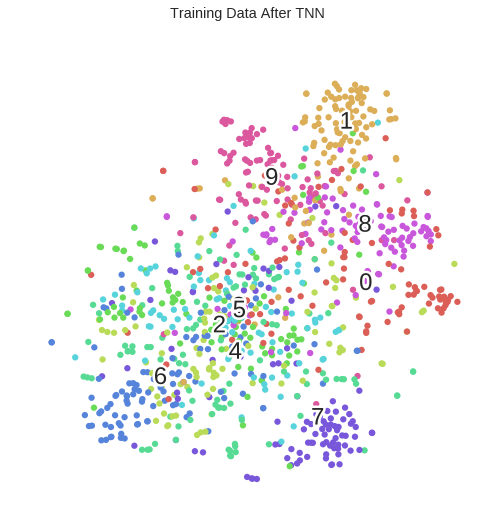

In [64]:
tsne = TSNE()
# print(x_train_vgg2[0])
X_train_trm = trained_model.predict(np.asarray(x_train_vgg2[:1024]))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
scatter(train_tsne_embeds, np.asarray(y_train[:1024]), "Training Data After TNN")


In [62]:
new_embeddings = trained_model.predict(np.asarray(x_train_vgg2))
print(KNN(new_embeddings, y_train))

[]
[0.5236057864598482]
[0.5236057864598482, 0.5752541521659168]
[0.5236057864598482, 0.5752541521659168, 0.5733544619258906]
[0.5236057864598482, 0.5752541521659168, 0.5733544619258906, 0.5323741728701405]
0.5317674880420953
